# Rationale
Let's train a RealPD-only network first, but I hope that there is an increase in metrics if we use both datasets together

In [1]:
import tensorflow as tf
import tf_mapper
from importlib import reload
import pandas as pd
import numpy as np
reload(tf_mapper)
from sklearn.model_selection import train_test_split
from tf_mapper import get_batched_dataset
# tf.enable_eager_execution()
# Helperfunctions to make your feature definition more readable

def read_tfrecord(example):
    features = { \
               'watch_accel':tf.io.FixedLenFeature([1500*3], tf.float32,),\
               'watch_gyro':tf.io.FixedLenFeature([1500*3], tf.float32,),\
               'watch_phone': tf.io.FixedLenFeature([1500*3], tf.float32,),\
               'has_watch_accel': tf.io.FixedLenFeature([1], tf.int64,),\
               'has_gyro':tf.io.FixedLenFeature([1], tf.int64,),\
               'has_phone': tf.io.FixedLenFeature([1], tf.int64,),\
               'on_off': tf.io.FixedLenFeature([1], tf.int64,),\
               'dyskinesia':tf.io.FixedLenFeature([1], tf.int64,),\
               'measurement_id': tf.io.FixedLenFeature([1], tf.int64,),\
               'tremor': tf.io.FixedLenFeature([1], tf.int64,),\
               'subjects': tf.io.FixedLenFeature([1], tf.int64,)
              }

    example = tf.io.parse_single_example(example, features)
    return example
def map_example_to_simple(example):
    data = example['watch_accel']
    data = tf.reshape(data, (1500,3))
    return data, (example['on_off'][0], example['tremor'][0], example['dyskinesia'][0])

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ms994/miniconda3/envs/keras-

In [2]:
def tf_is_in_set(a, b):
    return tf.reduce_sum(tf.cast(tf.equal(b, a), tf.int64)) >= 1

In [3]:

def get_batched_dataset(filenames, batch_size, m_ids, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
    dataset = dataset.cache()
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[0], -1))
    dataset = dataset.filter(lambda x, y: tf.reduce_any(tf.math.reduce_std(x, 0) > 0.05))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[1], -1))
    dataset = dataset.filter(lambda x, y: tf.not_equal(y[2], -1))
    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset

In [4]:
labels = pd.concat([pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv"),pd.read_csv("/home/ms994/beat_pd/data/real-pd/data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv")])

In [5]:
subject_specific = labels.groupby("subject_id").mean().dropna()

In [6]:
filledLabels = labels[labels.subject_id.isin(subject_specific.index)].dropna()
filledLabels = filledLabels.join(subject_specific, on="subject_id", rsuffix="_r")
((filledLabels.on_off - filledLabels.on_off_r)**2).mean(), ((filledLabels.dyskinesia - filledLabels.dyskinesia_r)**2).mean(), ((filledLabels.tremor - filledLabels.tremor_r)**2).mean()

(0.13361368303418647, 0.07335841192333417, 0.30432272522773124)

In [6]:
%%bash
ls /n/scratch2/beat_pd_ms_tmp

all_data.tfr
export.tar
real_pd_all_data.tfr


In [7]:
all_m_id = labels.measurement_id.unique().tolist()

In [8]:
train_ind, test_ind = train_test_split([i for i in range(len(all_m_id))], random_state=1)
train_ind, valid_ind = train_test_split(train_ind, random_state=1)

In [23]:
import pickle as pkl
allResults = pkl.load(open("/n/scratch2/ms994/realPd.pkl", "rb"))

In [24]:
len(allResults)

63262

In [31]:
allResults[1000][3]

measurement_id     72af00e8-1dd6-4fcf-a91d-c24445b6e173
smartphone_data                                    True
subject_id                                       hbv018
on_off                                              NaN
dyskinesia                                            1
tremor                                              NaN
device_id                                          2VSP
smartwatch_data                                    True
gyro_data                                          True
Name: 10, dtype: object

In [17]:
from sys import getsizeof

In [18]:
getsizeof(allResults)

569464

In [21]:
allResults = filter(lambda xy: not np.isnan(xy[3].on_off) and not np.isnan(xy[3].tremor) and not np.isnan(xy[3].dyskinesia) ,allResults)
allResults = list(allResults)

In [22]:
len(allResults)

4262

In [20]:
allResults[0][3]

measurement_id     439bc1b9-1b23-4691-a454-f4e1c7b8e4d9
smartphone_data                                    True
subject_id                                       hbv038
on_off                                                1
dyskinesia                                          NaN
tremor                                                3
device_id                                          2WH8
smartwatch_data                                    True
gyro_data                                          True
Name: 1, dtype: object

In [19]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 256, m_ids=train_ind, map_func=map_example_to_simple)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 256, m_ids=valid_ind, map_func=map_example_to_simple)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 256, m_ids=test_ind, map_func=map_example_to_simple)

In [21]:
iterator = test_data.take(5000).make_one_shot_iterator()

In [20]:
num_cnn_layers = 5
num_lstm_layers = 1
num_lin_layers = 5
dropout = 0.5
lin_h=128
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.005)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
    x = tf.keras.layers.BatchNormalization()(x)

for j in range(num_lstm_layers):
    x = tf.keras.layers.CuDNNLSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)



x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(lin_h)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=1)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=2)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])

In [21]:
model.compile(tf.keras.optimizers.Adam(lr=0.0005), loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ], loss_weights=[4,2,1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 1500, 3)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 1500, 16)     160         gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_44 (LeakyReLU)      (None, 1500, 16)     0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm_realpd_no_augment.h5", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)

history = model.fit(train_data, steps_per_epoch=250, epochs=200, validation_data=valid_data, validation_steps=50, callbacks=[modelCheckpoint, reduce_lr, earlyStopping])

Epoch 1/200
249/250 [============================>.] - ETA: 1s - loss: 3.0509 - on_off_loss: 0.2626 - dyskinesia_loss: 0.8247 - tremor_loss: 0.3510
Epoch 00001: val_loss improved from inf to 2.74410, saving model to /n/scratch2/ms994/cnnlstm_realpd_no_augment.h5
250/250 [==============================] - 376s 2s/step - loss: 3.0587 - on_off_loss: 0.2641 - dyskinesia_loss: 0.8262 - tremor_loss: 0.3497 - val_loss: 2.7441 - val_on_off_loss: 0.2697 - val_dyskinesia_loss: 0.6857 - val_tremor_loss: 0.2939
Epoch 2/200
116/250 [============>.................] - ETA: 2:31 - loss: 2.3968 - on_off_loss: 0.2408 - dyskinesia_loss: 0.5917 - tremor_loss: 0.2499

In [34]:
model.evaluate(test_data, steps=250)

250/250 [==============================] - 114s 458ms/step - loss: 3.3216 - on_off_loss: 0.4976 - dyskinesia_loss: 0.6519 - tremor_loss: 0.0272


[3.3215870444774627, 0.49763975, 0.651914, 0.027200917]

In [35]:
import matplotlib.pyplot as plt

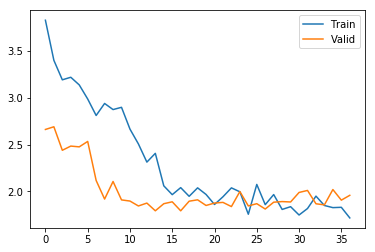

In [36]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Valid"])

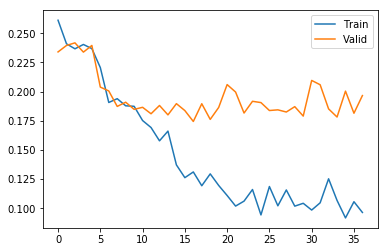

In [37]:
plt.plot(history.history["on_off_loss"])
plt.plot(history.history["val_on_off_loss"])
plt.legend(["Train", "Valid"])

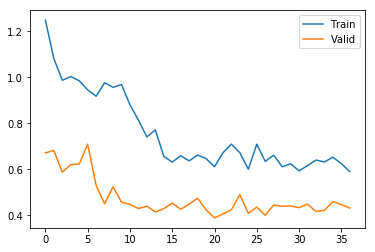

In [38]:
plt.plot(history.history["dyskinesia_loss"])
plt.plot(history.history["val_dyskinesia_loss"])
plt.legend(["Train", "Valid"])

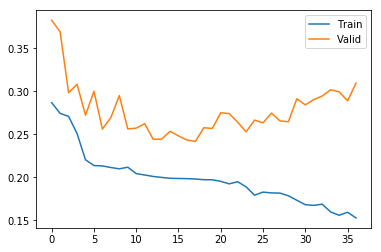

In [39]:
plt.plot(history.history["tremor_loss"])
plt.plot(history.history["val_tremor_loss"])
plt.legend(["Train", "Valid"])

In [42]:

%%bash
squeue -u ms994
scancel 6881629

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           6881629       gpu     bash    ms994  R    8:06:13      1 compute-g-16-255


# Try more data augmentation

In [11]:
#https://github.com/matthew-brett/transforms3d/blob/master/transforms3d/axangles.py
def tfaxangle2mat(x, y, z, angle, is_normalized=False):
#     x, y, z = axis
    if not is_normalized:
        n = tf.math.sqrt(x*x + y*y + z*z)
        x = x/n
        y = y/n
        z = z/n
    c = tf.math.cos(angle); s = tf.math.sin(angle); C = 1-c
    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC
    return tf.reshape(tf.concat([
             x*xC+c,   xyC-zs,   zxC+ys ,
             xyC+zs,   y*yC+c,   yzC-xs ,
             zxC-ys,   yzC+xs,   z*zC+c ], axis=-1), (3,3))

In [18]:
std = 1/16 #allow deviation from real rotation with pi/16 std
def map_example_to_simple_train(example):
    data = example['watch_accel']
    data = tf.reshape(data, (1500,3))
    update_matrix = tfaxangle2mat(tf.constant(0.0), tf.constant(0.0), tf.constant(1.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(0.0), tf.constant(1.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    update_matrix = update_matrix @ tfaxangle2mat(tf.constant(1.0), tf.constant(0.0), tf.constant(0.0), tf.random.normal((1,)) * tf.constant(3.14*std))
    data = data @ update_matrix
    return data, (example['on_off'][0], example['dyskinesia'][0], example['tremor'][0],)

In [19]:
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=train_ind, map_func=map_example_to_simple_train)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_simple)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_simple)

In [20]:
num_cnn_layers = 5
num_lstm_layers = 0
num_lin_layers = 5
dropout = 0.5
lin_h=128
inputLayer = tf.keras.layers.Input((1500, 3))
x = inputLayer
x = tf.keras.layers.GaussianNoise(0.005)(x)


for i in range(num_cnn_layers):
    x = tf.keras.layers.Conv1D(16, (3,), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool1D((2,))(x)
    x = tf.keras.layers.BatchNormalization()(x)

for j in range(num_lstm_layers):
    x = tf.keras.layers.CuDNNLSTM(16, return_sequences=True)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)



x = tf.keras.layers.Flatten(name="flatten_encoder_lstm")(x)
x = tf.keras.layers.Dense(lin_h)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x_shared_flattened = x

#one_off
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_on_off = tf.keras.layers.ReLU(name="on_off", max_value=1)(x)

#tremor
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_dyskinesia = tf.keras.layers.ReLU(name="dyskinesia", max_value=2)(x)

#montage classify
x = x_shared_flattened 
for k in range(num_lin_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(lin_h)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1)(x)
x_tremor = tf.keras.layers.ReLU(name="tremor", max_value=4)(x)



model = tf.keras.Model(inputs=inputLayer, outputs=[x_on_off, x_dyskinesia, x_tremor])
model.compile(tf.keras.optimizers.Adam(lr=0.001), loss=["mean_squared_error", "mean_squared_error", "mean_squared_error", ], loss_weights=[4,2,1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1500, 3)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 1500, 3)      0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1500, 16)     160         gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 1500, 16)     0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnnlstm_realpd.h5", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5)
history = model.fit(train_data, steps_per_epoch=500, epochs=200, validation_data=valid_data, validation_steps=100, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 2.8572 - on_off_loss: 0.2548 - dyskinesia_loss: 0.2827 - tremor_loss: 1.2724
Epoch 00001: val_loss improved from inf to 2.25072, saving model to /n/scratch2/ms994/cnnlstm_realpd.h5
500/500 [==============================] - 342s 684ms/step - loss: 2.8523 - on_off_loss: 0.2543 - dyskinesia_loss: 0.2822 - tremor_loss: 1.2706 - val_loss: 2.2507 - val_on_off_loss: 0.2341 - val_dyskinesia_loss: 0.4375 - val_tremor_loss: 0.4395
Epoch 2/200
499/500 [============================>.] - ETA: 0s - loss: 2.6136 - on_off_loss: 0.2416 - dyskinesia_loss: 0.2728 - tremor_loss: 1.1017
Epoch 00002: val_loss improved from 2.25072 to 2.16376, saving model to /n/scratch2/ms994/cnnlstm_realpd.h5
500/500 [==============================] - 311s 622ms/step - loss: 2.6121 - on_off_loss: 0.2411 - dyskinesia_loss: 0.2739 - tremor_loss: 1.0999 - val_loss: 2.1638 - val_on_off_loss: 0.2396 - val_dyskinesia_loss: 0.4391 - val_tremor_loss: 0.3272
Ep

In [27]:
model = tf.keras.models.load_model("/n/scratch2/ms994/cnnlstm_realpd.h5")

In [29]:
model.evaluate(test_data, steps=1000)

1000/1000 [==============================] - 403s 403ms/step - loss: 3.2436 - on_off_loss: 0.3885 - dyskinesia_loss: 0.7361 - tremor_loss: 0.2173


[3.243612763285637, 0.38854158, 0.7360737, 0.21729973]

# Dyskinesia specific only

In [43]:
def map_example_to_simple_dysk(example):
    data = example['watch_accel']
    data = tf.reshape(data, (1500,3))
    return data, example['dyskinesia'][0]
def get_batched_dataset_sing_out(filenames, batch_size, m_ids, map_func=None, max_queue_size=10,  n_process=4, is_train=False):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=3, num_parallel_calls=3)

    dataset = dataset.map(read_tfrecord, num_parallel_calls=n_process)
#     dataset = dataset.cache()
    dataset = dataset.filter(lambda example: tf_is_in_set(example["measurement_id"][0], tf.constant(m_ids, dtype=tf.int64)))
    dataset = dataset.map(map_func)
    dataset = dataset.filter(lambda x, y: tf.not_equal(y, -1))
    dataset = dataset.filter(lambda x, y: tf.math.reduce_std(x, 0) > 0.05)
    

    
    dataset = dataset.repeat()
    if is_train:
        dataset = dataset.shuffle(2056)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if is_train:
        dataset = dataset.prefetch(max_queue_size)
    else:
        dataset = dataset.prefetch(int(max_queue_size/4)) #store a lot less for the other sets to avoid wasting memory

    return dataset
train_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=train_ind, map_func=map_example_to_simple_dysk)
valid_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=valid_ind, map_func=map_example_to_simple_dysk)
test_data = get_batched_dataset("/n/scratch2/beat_pd_ms_tmp/real_pd_all_data.tfr", 128, m_ids=test_ind,  map_func=map_example_to_simple_dysk)

ValueError: Index out of range using input dim 0; input has only 0 dims for 'strided_slice' (op: 'StridedSlice') with input shapes: [], [1], [1], [1] and with computed input tensors: input[3] = <1>.